<a href="https://colab.research.google.com/github/Uditsingh7/Deep_Learning_Projects/blob/main/Udit_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: uditsinghthakur
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:00<00:00, 1.29GB/s]


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [5]:

image_path = [] # Empty array where we will fill the paths of the images
labels = [] # Empty array where we will fill the labes of the images

for i in os.listdir("/content/animal-faces/afhq/"): # Looping through the first directory which has the train and val images
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"): # Looping through the first directory which has the labels folders
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}") # Append/Put this image path in the list to read it later

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels
data_df.tail() # Visualizing the first 5 rows

,image_paths,labels
16125,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
16126,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
16127,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
16128,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog
16129,/content/animal-faces/afhq/val/dog/pixabay_dog...,dog


In [6]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [7]:
test.shape

(2419, 2)

In [8]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(data_df['labels']) # Fit the label encoder on our own data

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

In [10]:
class CustomImageDataset(Dataset):
    """
    A custom dataset class for loading images and their labels from a DataFrame.
    Designed for PyTorch deep learning pipelines.
    """

    def __init__(self, dataframe, transform=None):
        # Store the DataFrame containing image paths & labels
        self.dataframe = dataframe

        # Store any image preprocessing or augmentation transforms
        self.transform = transform

        # Encode string labels into integer class IDs
        # label_encoder.transform converts labels -> numerical indices (e.g., "cat" -> 0, "dog" -> 1)
        # torch.tensor(...) makes them usable for training
        # .to(device) moves them directly to GPU/CPU for faster access during training
        self.labels = torch.tensor(
            label_encoder.transform(dataframe['labels'])
        ).to(device)

    def __len__(self):
        # Return total number of samples
        # Needed so PyTorch DataLoader knows how many batches to create
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        # Get the image path from the DataFrame
        img_path = self.dataframe.iloc[idx, 0]

        # Get the corresponding encoded label
        label = self.labels[idx]

        # Load the image and ensure it's in RGB format (avoids grayscale or RGBA mismatch)
        image = Image.open(img_path).convert('RGB')

        # Apply any preprocessing/augmentation transforms if provided
        # Moving to device here means preprocessing happens on CPU, then tensor is moved to GPU
        if self.transform:
            image = self.transform(image).to(device)

        # Return the processed image tensor and label
        return image, label


In [12]:
# Create the training dataset
# - Uses images & labels from the 'train' DataFrame
# - transform applies preprocessing & augmentation (e.g., resize, normalize, random flip)
# - Augmentation is typically ON here to help the model generalize
train_dataset = CustomImageDataset(dataframe=train, transform=transform)

# Create the validation dataset
# - Uses the 'val' DataFrame
# - transform should usually have NO augmentation (only resize & normalize)
#   so evaluation reflects real-world performance without artificial changes
val_dataset = CustomImageDataset(dataframe=val, transform=transform)

# Create the test dataset
# - Uses the 'test' DataFrame
# - Same logic as validation: minimal transform, no augmentation
#   ensures fair, unbiased final performance measurement
test_dataset = CustomImageDataset(dataframe=test, transform=transform)


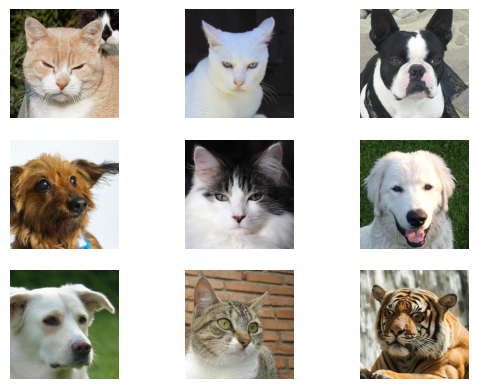

In [15]:
# Number of rows and columns for the image grid
n_rows = 3
n_cols = 3

# Create a matplotlib figure with a grid of subplots
# - Each subplot will hold one image
f, axarr = plt.subplots(n_rows, n_cols)

# Loop through each grid cell
for row in range(n_rows):
    for col in range(n_cols):
        # Randomly select 1 image path from the dataframe
        # .sample(n=1) → random row
        img_path = data_df.sample(n=1)['image_paths'].iloc[0]

        # Open the image and convert to RGB to ensure 3 channels
        image = Image.open(img_path).convert("RGB")

        # Show the image in the current subplot
        axarr[row, col].imshow(image)

        # Hide the axis ticks/labels for cleaner visualization
        axarr[row, col].axis('off')

# Display the entire grid of images
plt.show()


In [18]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10


In [19]:
# DataLoader for the training set
# - batch_size: number of samples fed to the model in one forward/backward pass
# - shuffle=True: important for training so batches are randomized each epoch
#   → prevents model from learning any accidental ordering patterns in the data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# DataLoader for the validation set
# - batch_size: usually same as train, but can be larger since no backprop
# - shuffle=True here is optional (doesn't affect metrics, but randomizes order)
# - Main goal: evaluate performance on unseen data during training
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# DataLoader for the test set
# - Used only after training is complete to report final model performance
# - shuffle=True doesn’t matter here since evaluation is order-independent
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolution layer: input has 3 channels (RGB), output 32 feature maps
        # Kernel size 3x3, padding=1 to preserve spatial size
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # Second convolution: input 32 channels, output 64 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Third convolution: input 64 channels, output 128 feature maps
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Max pooling layer: reduces HxW by factor of 2 each time (2x2 window)
        self.pooling = nn.MaxPool2d(2, 2)

        # ReLU activation to introduce non-linearity
        self.relu = nn.ReLU()

        # Flatten the 3D feature maps into a 1D vector for the fully connected layer
        self.flatten = nn.Flatten()

        # Fully connected layer: takes (128 channels * 16 * 16 spatial size) → 128 hidden units
        self.linear = nn.Linear(128 * 16 * 16, 128)

        # Output layer: maps hidden units to number of classes in dataset
        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        # Layer 1: Conv → Pool → ReLU
        # Input: (3, 128, 128) → Conv1: (32, 128, 128) → Pool: (32, 64, 64)
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)

        # Layer 2: Conv → Pool → ReLU
        # Input: (32, 64, 64) → Conv2: (64, 64, 64) → Pool: (64, 32, 32)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)

        # Layer 3: Conv → Pool → ReLU
        # Input: (64, 32, 32) → Conv3: (128, 32, 32) → Pool: (128, 16, 16)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)

        # Flatten feature maps to 1D: (128*16*16)
        x = self.flatten(x)

        # Fully connected hidden layer
        x = self.linear(x)

        # Output layer: class scores
        x = self.output(x)

        return x

# Create an instance of the model and move it to GPU
model = Net().to(device)



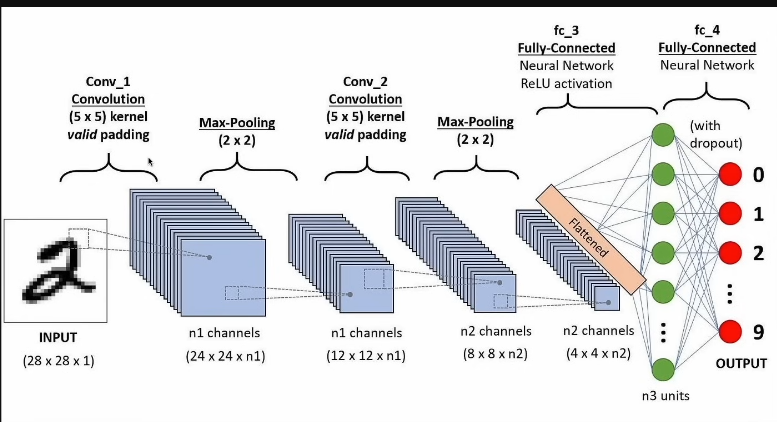

This CNN takes a 28x28 grayscale image as input and passes it through two convolutional layers.
The first convolution (5x5 filters, valid padding) extracts low-level features (edges, curves)
and outputs feature maps of size 24x24xn1, followed by 2x2 max-pooling to reduce it to 12x12xn1.

The second convolution (5x5 filters) learns higher-level features (shapes, patterns)
reducing size to 8x8xn2, then another 2x2 max-pooling compresses it to 4x4xn2.
This makes the model efficient and more robust to shifts.

The 3D output is flattened into a 1D vector, then passed through a fully connected (dense) layer
with ReLU activation to combine features and make abstract decisions.

Finally, the last dense layer outputs scores for each class (0–9),
with dropout applied to reduce overfitting. Softmax is used later to get probabilities.


In [23]:
# Create an instance of the Net class (our CNN model)
# .to(device) moves the model's parameters to the GPU if available,
# so all computations happen on the GPU instead of the CPU.
model = Net().to(device)


In [25]:
from torchsummary import summary

# Prints a layer-by-layer summary of the model:
# - Layer types & output shapes
# - Number of parameters per layer
# - Total trainable & non-trainable parameters
# input_size specifies the shape of a single input sample:
#   (3, 128, 128) = 3 color channels, 128x128 pixels
summary(model, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [26]:
# Define loss function and optimizer

# CrossEntropyLoss is used for multi-class classification.
# It combines LogSoftmax + Negative Log Likelihood in one step.
criterion = nn.CrossEntropyLoss()

# Adam optimizer adjusts learning rates adaptively for each parameter.
# model.parameters() gives all learnable weights & biases in the model.
# lr=LR sets the learning rate (speed of learning).
optimizer = Adam(model.parameters(), lr=LR)


In [27]:
# ===============================
# Training & Validation Loop
# This section performs iterative training over multiple epochs.
# Each epoch includes:
#  1. Training phase: model learns from the training dataset
#  2. Validation phase: model is evaluated on unseen validation data to check generalization
# Metrics (loss & accuracy) are tracked for both phases.
# ===============================

# Lists to store metrics after each epoch for visualization & analysis later
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    # These variables reset every epoch to accumulate values for this specific epoch
    total_acc_train = 0     # Total correct predictions on training set
    total_loss_train = 0    # Sum of training loss values
    total_loss_val = 0      # Sum of validation loss values
    total_acc_val = 0       # Total correct predictions on validation set

    # -------- TRAINING PHASE --------
    # Model updates its parameters based on training data
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Q: Why?
                               # A: To clear previous gradients from last batch,
                               #    otherwise they accumulate in PyTorch.

        outputs = model(inputs)  # Forward pass → raw predictions (logits)

        train_loss = criterion(outputs, labels)
        # CrossEntropyLoss combines Softmax + Negative Log Likelihood internally.
        # Q: Why CrossEntropy for classification?
        # A: It penalizes wrong predictions proportionally to confidence level,
        #    making it ideal for multi-class classification.

        total_loss_train += train_loss.item()  # .item() → get scalar value for logging

        train_loss.backward()  # Backpropagation: compute gradients wrt loss
        # Q: Why backward here?
        # A: Without this step, no weight updates happen. It propagates error
        #    through the network so optimizer can adjust weights.

        # Calculate accuracy for this batch
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()  # Update parameters based on calculated gradients
        # Q: Why step after every batch?
        # A: This implements mini-batch gradient descent, which is more stable
        #    and memory-efficient than full batch.

    # -------- VALIDATION PHASE --------
    # Model does NOT update parameters — just evaluates performance
    with torch.no_grad():  # Saves memory & speeds up, since we skip gradient calculation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            # Accuracy calculation
            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    # -------- METRIC STORAGE --------
    # We divide losses by 1000 here (scaling choice by author — might be dataset-size specific)
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 1000, 4))

    # Accuracy is converted to percentage
    total_acc_train_plot.append(round(total_acc_train / len(train_dataset) * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val / len(val_dataset) * 100, 4))

    # -------- EPOCH SUMMARY PRINT --------
    print(f'''Epoch {epoch+1}/{EPOCHS},
              Train Loss: {round(total_loss_train/100, 4)}
              Train Accuracy: {round(total_acc_train / len(train_dataset) * 100, 4)}%
              Validation Loss: {round(total_loss_val/100, 4)}
              Validation Accuracy: {round(total_acc_val / len(val_dataset) * 100, 4)}%''')
    print("=" * 25)


Epoch 1/10, 
              Train Loss: 3.3664 
              Train Accuracy: 80.2763%
              Validation Loss: 0.3632 
              Validation Accuracy: 91.7769%
Epoch 2/10, 
              Train Loss: 1.2923 
              Train Accuracy: 93.2955%
              Validation Loss: 0.2215 
              Validation Accuracy: 94.876%
Epoch 3/10, 
              Train Loss: 0.799 
              Train Accuracy: 95.8994%
              Validation Loss: 0.1842 
              Validation Accuracy: 95.4959%
Epoch 4/10, 
              Train Loss: 0.5759 
              Train Accuracy: 97.1925%
              Validation Loss: 0.1671 
              Validation Accuracy: 95.9504%
Epoch 5/10, 
              Train Loss: 0.4225 
              Train Accuracy: 97.8213%
              Validation Loss: 0.1769 
              Validation Accuracy: 96.0744%
Epoch 6/10, 
              Train Loss: 0.2819 
              Train Accuracy: 98.6892%
              Validation Loss: 0.1648 
              Validation Accurac

In [29]:
# ===============================
# TESTING PHASE
# Inference on completely unseen data (test set) to evaluate final model performance.
# The model does NOT learn here — this is purely to measure generalization ability.
# ===============================

with torch.no_grad():
    # Q: Why torch.no_grad()?
    # A: Inference doesn’t require gradient tracking, so we disable it to:
    #    - Reduce memory usage
    #    - Speed up computations
    #    - Prevent accidental gradient updates

    total_loss_test = 0   # Accumulate total loss across all test batches
    total_acc_test = 0    # Accumulate number of correct predictions

    for inputs, labels in test_loader:
        predictions = model(inputs)  # Forward pass → raw logits

        # Compute accuracy for this batch
        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        # Q: Why torch.argmax?
        # A: Argmax picks the class index with the highest predicted probability (logit).
        #    This index is compared to the ground truth label to check if the prediction is correct.
        total_acc_test += acc

        # Compute loss for this batch
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

# ===============================
# FINAL METRIC OUTPUT
# Accuracy is computed as correct predictions / total samples.
# Loss is reported as a scaled average (here divided by 1000 per author’s convention).
# ===============================
print(f"Accuracy Score is: {round((total_acc_test / len(test_dataset)) * 100, 4)}% "
      f"and Loss is {round(total_loss_test / 1000, 4)}")


Accuracy Score is: 96.3208% and Loss is 0.0225


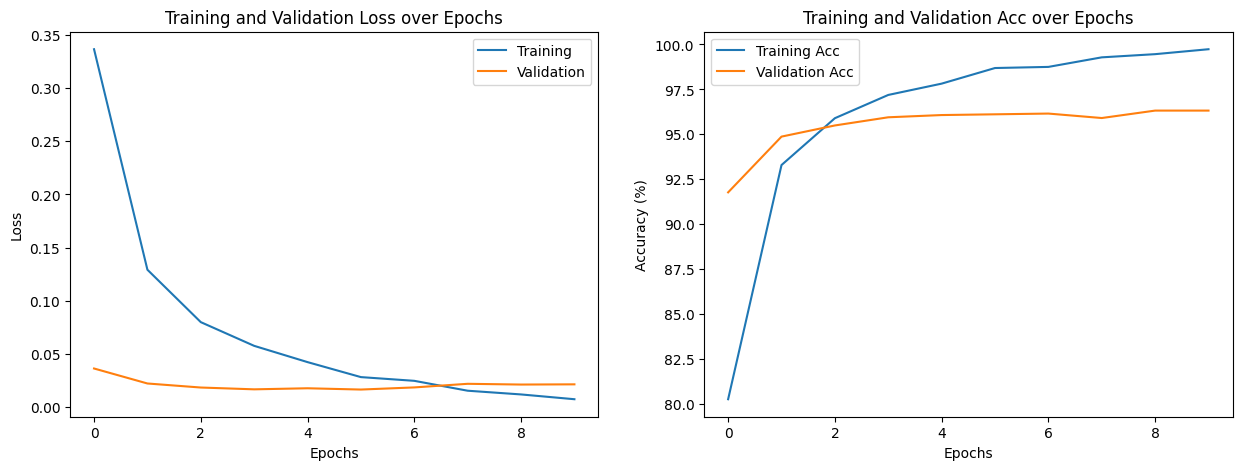

In [33]:
# ============================================
# MODEL PERFORMANCE VISUALIZATION
# Plot Training vs Validation Loss & Accuracy over epochs.
# This is essential for diagnosing model behavior:
# - Detecting underfitting / overfitting
# - Checking if the model is converging
# - Evaluating effect of hyperparameters
# ============================================

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))  # Create a figure with 2 side-by-side subplots

# ------------------------------
# LOSS PLOT (Left side)
# ------------------------------
axs[0].plot(total_loss_train_plot, label="Training")      # Plot training loss
axs[0].plot(total_loss_validation_plot, label="Validation")  # Plot validation loss
axs[0].set_title("Training and Validation Loss over Epochs") # Chart title
axs[0].set_xlabel("Epochs")                               # X-axis label
axs[0].set_ylabel("Loss")                                 # Y-axis label
axs[0].legend()  # Shows the label for each plotted line so we know which is training vs validation
# NOTE: Without legend(), both lines would appear but you wouldn't know which is which.

# Q: Why plot Loss?
# A: Loss measures the model's prediction error.
#    - If both training & validation loss go down together → good learning.
#    - If training loss keeps dropping but validation loss rises → overfitting.
#    - If both losses stay high → underfitting.

# ------------------------------
# ACCURACY PLOT (Right side)
# ------------------------------
axs[1].plot(total_acc_train_plot, label="Training Acc")    # Training accuracy line
axs[1].plot(total_acc_validation_plot, label="Validation Acc") # Validation accuracy line
axs[1].set_title("Training and Validation Acc over Epochs") # Chart title
axs[1].set_xlabel("Epochs")                               # X-axis label
axs[1].set_ylabel("Accuracy (%)")                         # Y-axis label
axs[1].legend()  # Helps identify which line represents training accuracy vs validation accuracy

# Q: Why Accuracy too?
# A: Accuracy tells how many predictions are correct.
#    - Loss is a continuous measure, accuracy is discrete performance metric.
#    - Both are needed since loss can drop even if accuracy doesn't improve
#      (e.g., probabilities becoming more confident but not flipping wrong predictions).

# ------------------------------
# SHOW FINAL VISUALIZATION
# ------------------------------
plt.show()


In [42]:
# 1- read the image
# 2- Transform sing transform object
# 3- predict throgh the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  print(image.shape)
  print(image.unsqueeze(0).shape)
  output = model(image.unsqueeze(0))

  output = torch.argmax(output, axis=1).item()

  return label_encoder.inverse_transform([output])

In [43]:
predict_image("/content/cat.jpg")

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


array(['dog'], dtype=object)

In [44]:
# ============================================
# IMAGE PREDICTION FUNCTION
# Steps:
# 1. Read the image
# 2. Apply the same transforms used during training
# 3. Pass through the trained model to get predictions
# 4. Convert numerical label → original class name using label encoder
# ============================================

def predict_image(image_path):
    # 1. LOAD IMAGE
    # Open the image file, ensure it's in RGB (3 channels) to match training data
    image = Image.open(image_path).convert('RGB')

    # 2. APPLY PREPROCESSING TRANSFORMS
    # 'transform' is the same torchvision pipeline (resize, normalize, tensor conversion)
    # used in training so the model sees consistent input format.
    image = transform(image).to(device)  # Move tensor to same device as model (CPU/GPU)

    # Debug: Check shape after transform
    # Output shape is (C, H, W) → e.g., (3, 128, 128)
    print(image.shape)

    # 3. ADD BATCH DIMENSION
    # PyTorch models expect input shape (batch_size, C, H, W)
    # unsqueeze(0) adds a batch dimension at index 0
    print(image.unsqueeze(0).shape)  # e.g., (1, 3, 128, 128)

    # 4. MODEL PREDICTION
    # Forward pass through model to get raw logits for each class
    output = model(image.unsqueeze(0))

    # 5. GET PREDICTED CLASS INDEX
    # torch.argmax → gets index of highest score along class dimension
    output = torch.argmax(output, axis=1).item()

    # 6. INVERSE TRANSFORM TO CLASS NAME
    # label_encoder.inverse_transform → converts numeric index → original label string
    return label_encoder.inverse_transform([output])
